In [2]:
!pip install OpenEXR Imath
# !pip install opencv-python
import torch
import OpenEXR, Imath
import numpy as np
from PIL import Image
from torchvision import transforms
from torchvision.transforms.functional import normalize as F_normalize
import cv2
import torch.nn as nn
from torchvision.models.detection import retinanet_resnet50_fpn
import torchvision
import functools
import torch.nn.functional as F
from torch.nn.functional import interpolate as F_upsample
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.2 MB/s eta 0:00:00
Mounted at /content/drive


In [3]:
class EfficientAttention(nn.Module):
    def __init__(self, val_channels=3, key_channels=4, in_channels=0):
        super().__init__()
        self.in_channels = in_channels if in_channels else val_channels
        self.key_channels = key_channels
        self.val_channels = val_channels

        self.keys = nn.Conv2d(self.val_channels, self.key_channels, 1)
        self.values = nn.Conv2d(self.val_channels, self.key_channels, 1)
        self.queries = nn.Conv2d(self.in_channels, self.key_channels, 1)
        self.reprojection = nn.Conv2d(self.key_channels, self.val_channels, 1)

    def forward(self, value_, input_=None):
        n, c, h, w = value_.size()
        values = self.values(value_).reshape((n, self.key_channels, h * w))
        keys = self.keys(value_).reshape((n, self.key_channels, h * w))

        if input_ is not None:
            queries = self.queries(input_)

            # maxpool the query if it is larger than the value
            _, _, h_i, w_i = input_.size()
            if w_i > w or h_i > h:
                queries = F.max_pool2d(queries, (h_i//h, w_i//w))

            queries = queries.reshape(n, self.key_channels, h * w)
        else:
            queries = self.queries(value_).reshape(n, self.key_channels, h * w)

        key = F.softmax(keys, dim=2)
        query = F.softmax(queries, dim=1)

        context = key @ values.transpose(1, 2)
        attention = (
            context.transpose(1, 2) @ query
        ).reshape(n, self.key_channels, h, w)

        reprojected_value = self.reprojection(attention)
        attention = reprojected_value + value_
        return attention

In [4]:
class UnetGeneratorBilinear(nn.Module):
    def __init__(self, norm_layer):
        super(UnetGeneratorBilinear, self).__init__()

        use_bias = norm_layer == nn.InstanceNorm2d

        self.normalize = True
        self.self_attention = True
        self.use_avgpool = True
        self.skip = 0.8
        self.use_tanh = True
        # if self.use_tanh:
        #     if opt.hardtanh:
        self.final_tanh = nn.Hardtanh()
            # else:
            #     self.final_tanh = nn.Tanh()

        p = 1
        if self.self_attention:
            self.conv1_1 = nn.Conv2d(6, 32, 3, padding=p)
            self.attention_in = EfficientAttention(val_channels=3, key_channels=3, in_channels=3)
            self.attention_out = EfficientAttention(val_channels=3, key_channels=3, in_channels=3)
            self.attention_1 = EfficientAttention(val_channels=32, key_channels=4, in_channels=3)
            self.attention_2 = EfficientAttention(val_channels=64, key_channels=4, in_channels=3)
            self.attention_3 = EfficientAttention(val_channels=128, key_channels=8, in_channels=3)
            self.attention_4 = EfficientAttention(val_channels=512, key_channels=16, in_channels=3)
        else:
            self.conv1_1 = nn.Conv2d(3, 32, 3, padding=p)

        self.LReLU1_1 = nn.LeakyReLU(0.2, inplace=True)
        self.bn1_1 = norm_layer(32)
        self.conv1_2 = nn.Conv2d(32, 32, 3, padding=p)
        self.LReLU1_2 = nn.LeakyReLU(0.2, inplace=True)
        self.bn1_2 = norm_layer(32)
        self.max_pool1 = nn.AvgPool2d(2) if self.use_avgpool == 1 else nn.MaxPool2d(2)

        self.conv2_1 = nn.Conv2d(32, 64, 3, padding=p)
        self.LReLU2_1 = nn.LeakyReLU(0.2, inplace=True)
        self.bn2_1 = norm_layer(64)
        self.conv2_2 = nn.Conv2d(64, 64, 3, padding=p)
        self.LReLU2_2 = nn.LeakyReLU(0.2, inplace=True)
        self.bn2_2 = norm_layer(64)
        self.max_pool2 = nn.AvgPool2d(2) if self.use_avgpool == 1 else nn.MaxPool2d(2)

        self.conv3_1 = nn.Conv2d(64, 128, 3, padding=p)
        self.LReLU3_1 = nn.LeakyReLU(0.2, inplace=True)
        self.bn3_1 = norm_layer(128)
        self.conv3_2 = nn.Conv2d(128, 128, 3, padding=p)
        self.LReLU3_2 = nn.LeakyReLU(0.2, inplace=True)
        self.bn3_2 = norm_layer(128)
        self.max_pool3 = nn.AvgPool2d(2) if self.use_avgpool == 1 else nn.MaxPool2d(2)

        self.conv4_11 = nn.Conv2d(128, 128, 1, padding=p*0)
        self.LReLU4_11 = nn.LeakyReLU(0.2, inplace=True)
        self.bn4_11 = norm_layer(128)
        self.conv4_12 = nn.Conv2d(128, 128, 3, padding=p*1)
        self.LReLU4_12 = nn.LeakyReLU(0.2, inplace=True)
        self.bn4_12 = norm_layer(128)
        self.conv4_13 = nn.Conv2d(128, 128, 5, padding=p*2)
        self.LReLU4_13 = nn.LeakyReLU(0.2, inplace=True)
        self.bn4_13 = norm_layer(128)
        self.conv4_14 = nn.Conv2d(128, 128, 7, padding=p*3)
        self.LReLU4_14 = nn.LeakyReLU(0.2, inplace=True)
        self.bn4_14 = norm_layer(128)
        self.conv4_2 = nn.Conv2d(512, 256, 3, padding=p)
        self.LReLU4_2 = nn.LeakyReLU(0.2, inplace=True)
        self.bn4_2 = norm_layer(256)


        # Uncomment this block for further downsampling
        '''
        self.max_pool4 = nn.AvgPool2d(2) if self.use_avgpool == 1 else nn.MaxPool2d(2)

        self.conv5_1 = nn.Conv2d(256, 512, 3, padding=p)
        self.LReLU5_1 = nn.LeakyReLU(0.2, inplace=True)
        self.bn5_1 = norm_layer(512)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=p)
        self.LReLU5_2 = nn.LeakyReLU(0.2, inplace=True)
        self.bn5_2 = norm_layer(512)


        self.deconv5 = nn.Conv2d(512, 256, 3, padding=p)
        self.conv6_1 = nn.Conv2d(512, 256, 3, padding=p)
        self.LReLU6_1 = nn.LeakyReLU(0.2, inplace=True)
        self.bn6_1 = norm_layer(256)
        self.conv6_2 = nn.Conv2d(256, 256, 3, padding=p)
        self.LReLU6_2 = nn.LeakyReLU(0.2, inplace=True)
        self.bn6_2 = norm_layer(256)
        '''

        self.deconv6 = nn.Conv2d(256, 128, 3, padding=p)
        self.conv7_1 = nn.Conv2d(256, 128, 3, padding=p)
        self.LReLU7_1 = nn.LeakyReLU(0.2, inplace=True)
        self.bn7_1 = norm_layer(128)
        self.conv7_2 = nn.Conv2d(128, 128, 3, padding=p)
        self.LReLU7_2 = nn.LeakyReLU(0.2, inplace=True)
        self.bn7_2 = norm_layer(128)

        self.deconv7 = nn.Conv2d(128, 64, 3, padding=p)
        self.conv8_1 = nn.Conv2d(128, 64, 3, padding=p)
        self.LReLU8_1 = nn.LeakyReLU(0.2, inplace=True)
        self.bn8_1 = norm_layer(64)
        self.conv8_2 = nn.Conv2d(64, 64, 3, padding=p)
        self.LReLU8_2 = nn.LeakyReLU(0.2, inplace=True)
        self.bn8_2 = norm_layer(64)

        self.deconv8 = nn.Conv2d(64, 32, 3, padding=p)
        self.conv9_1 = nn.Conv2d(64, 32, 3, padding=p)
        self.LReLU9_1 = nn.LeakyReLU(0.2, inplace=True)
        self.bn9_1 = norm_layer(32)
        self.conv9_2 = nn.Conv2d(32, 32, 3, padding=p)
        self.LReLU9_2 = nn.LeakyReLU(0.2, inplace=True)

        self.conv10 = nn.Conv2d(32, 3, 1)

    def forward(self, input):
        if self.self_attention:
            attended_inp = self.attention_in(input)
            x = self.bn1_1(self.LReLU1_1(self.conv1_1(torch.cat([input, attended_inp], dim=1))))
        else:
            x = self.bn1_1(self.LReLU1_1(self.conv1_1(input)))
        conv1 = self.bn1_2(self.LReLU1_2(self.conv1_2(x)))
        x = self.max_pool1(conv1)

        x = self.bn2_1(self.LReLU2_1(self.conv2_1(x)))
        conv2 = self.bn2_2(self.LReLU2_2(self.conv2_2(x)))
        x = self.max_pool2(conv2)

        x = self.bn3_1(self.LReLU3_1(self.conv3_1(x)))
        conv3 = self.bn3_2(self.LReLU3_2(self.conv3_2(x)))
        x = self.max_pool3(conv3)

        ########## Starts: Bottom of the U-NET ##########
        x_1 = self.bn4_11(self.LReLU4_11(self.conv4_11(x)))
        x_2 = self.bn4_12(self.LReLU4_12(self.conv4_12(x)))
        x_3 = self.bn4_13(self.LReLU4_13(self.conv4_13(x)))
        x_4 = self.bn4_14(self.LReLU4_14(self.conv4_14(x)))
        x = torch.cat([x_1,x_2,x_3,x_4], dim=1)
        x = self.attention_4(x, input) if self.self_attention else x
        conv6 = self.bn4_2(self.LReLU4_2(self.conv4_2(x)))

        # uncomment this block for further downsampling
        '''
        x = self.bn4_1(self.LReLU4_1(self.conv4_1(x)))
        conv4 = self.bn4_2(self.LReLU4_2(self.conv4_2(x)))
        x = self.max_pool4(conv4)

        x = self.bn5_1(self.LReLU5_1(self.conv5_1(x)))
        #x = x*attention_map5 if self.self_attention else x
        x = self.attention_5(x) if self.self_attention else x
        conv5 = self.bn5_2(self.LReLU5_2(self.conv5_2(x)))

        conv5 = F_upsample(conv5, scale_factor=2, mode='bilinear')
        #conv4 = conv4*attention_map4 if self.self_attention else conv4
        conv4 = self.attention_4(conv4) if self.self_attention else conv4
        up6 = torch.cat([self.deconv5(conv5), conv4], 1)
        x = self.bn6_1(self.LReLU6_1(self.conv6_1(up6)))
        conv6 = self.bn6_2(self.LReLU6_2(self.conv6_2(x)))
        '''
        ########### Ends: Bottom of the U-NET ##########

        conv6 = F_upsample(conv6, scale_factor=2, mode='bilinear')
        conv3 = self.attention_3(conv3, input) if self.self_attention else conv3
        up7 = torch.cat([self.deconv6(conv6), conv3], 1)
        x = self.bn7_1(self.LReLU7_1(self.conv7_1(up7)))
        conv7 = self.bn7_2(self.LReLU7_2(self.conv7_2(x)))

        conv7 = F_upsample(conv7, scale_factor=2, mode='bilinear')
        conv2 = self.attention_2(conv2, input) if self.self_attention else conv2
        up8 = torch.cat([self.deconv7(conv7), conv2], 1)
        x = self.bn8_1(self.LReLU8_1(self.conv8_1(up8)))
        conv8 = self.bn8_2(self.LReLU8_2(self.conv8_2(x)))

        conv8 = F_upsample(conv8, scale_factor=2, mode='bilinear')
        conv1 = self.attention_1(conv1, input) if self.self_attention else conv1
        up9 = torch.cat([self.deconv8(conv8), conv1], 1)
        x = self.bn9_1(self.LReLU9_1(self.conv9_1(up9)))
        conv9 = self.LReLU9_2(self.conv9_2(x))

        latent = self.conv10(conv9)
        latent = self.attention_out(latent, input) if self.self_attention else latent

        if self.skip:
            if self.normalize:
                min_latent = torch.amin(latent, dim=(0,2,3), keepdim=True)
                max_latent = torch.amax(latent, dim=(0,2,3), keepdim=True)
                latent = (latent - min_latent) / (max_latent - min_latent)

            output = latent + self.skip * input
        else:
            output = latent

        if self.use_tanh:
            output = self.final_tanh(output)

        return output


In [5]:
num_classes = 7
norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)

det_model=retinanet_resnet50_fpn(pretrained=True)
in_features=det_model.head.classification_head.conv[0].out_channels
det_model.head.classification_head=torchvision.models.detection.retinanet.RetinaNetClassificationHead(
   in_channels=in_features,
    num_anchors=det_model.head.classification_head.num_anchors,
    num_classes=num_classes
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:01<00:00, 71.4MB/s]


In [6]:
# Add Generator Model path here

# gen_model_path = "../Models/best_gan_model.pt"
ggen_model_path = "drive/MyDrive/Models/best_gan_model.pt"

# Add Detector Model path here

# det_model_path = "../Models/best_detector_model.pt"
gdet_model_path = 'drive/MyDrive/Models/best_detector_model.pt'

gen_model = UnetGeneratorBilinear(norm_layer=norm_layer)

# gen_model_state_dict = torch.load(gen_model_path, map_location=torch.device('cpu'))
# det_model_state_dict = torch.load(det_model_path, map_location=torch.device('cpu'))
gen_model_state_dict = torch.load(ggen_model_path)
det_model_state_dict = torch.load(gdet_model_path)


gen_model.load_state_dict(gen_model_state_dict)
det_model.load_state_dict(det_model_state_dict)

gen_model.eval()
det_model.eval()

print(type(gen_model), "successfully loaded generator")
print(type(det_model), "successfully loaded detector")

<class '__main__.UnetGeneratorBilinear'> successfully loaded generator
<class 'torchvision.models.detection.retinanet.RetinaNet'> successfully loaded detector


In [7]:
def load_exr(filename):
    """Load an EXR file and return as a NumPy array."""
    file = OpenEXR.InputFile(filename)
    dw = file.header()['dataWindow']
    size = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)

    pt = Imath.PixelType(Imath.PixelType.FLOAT)
    channels = ['R', 'G', 'B']

    rgb = [np.frombuffer(file.channel(c, pt), dtype=np.float32) for c in channels]
    rgb = [np.reshape(c, (size[1], size[0])) for c in rgb]

    image = np.stack(rgb, axis=-1)
    # image = image.resize((1080,1920), Image.LANCZOS)
    return image

def hdr_normalize(img):
    hdr_max=65830.18848
    hdr_min=-326.18848
    real_A = F_normalize(img,
                        [hdr_min, hdr_min, hdr_min],
                        [hdr_max, hdr_max, hdr_max])
    return real_A

In [8]:
exr_path = "drive/MyDrive/Test Images/hdr_01268.exr"

exr_image = load_exr(exr_path)
exr_image = torch.tensor(exr_image).permute(2,0,1)

transform_img = transforms.Resize((1080,1920))

exr_image = transform_img(exr_image)

print(exr_image)

norm_exr_img = hdr_normalize(exr_image)
norm_exr_img = norm_exr_img.unsqueeze(0)
print(norm_exr_img.shape)

print(norm_exr_img)

print(torch.min(norm_exr_img), torch.min(exr_image))
print(torch.max(norm_exr_img), torch.max(exr_image))

tensor([[[35.8438, 35.4219, 35.0938,  ...,  1.8255,  1.8379,  1.8359],
         [36.6562, 35.3203, 34.0911,  ...,  1.8045,  1.8184,  1.8213],
         [37.6302, 35.1068, 32.6949,  ...,  1.7833,  1.7959,  1.8027],
         ...,
         [ 2.6117,  2.6047,  2.6038,  ...,  1.0297,  1.0050,  0.9839],
         [ 2.6143,  2.6064,  2.5994,  ...,  0.9942,  0.9758,  0.9614],
         [ 2.6016,  2.6016,  2.5986,  ...,  0.9668,  0.9561,  0.9492]],

        [[37.9062, 35.7188, 33.5052,  ...,  1.5745,  1.5703,  1.5713],
         [39.5312, 36.2969, 33.0339,  ...,  1.5622,  1.5608,  1.5635],
         [41.8385, 37.1849, 32.4792,  ...,  1.5513,  1.5555,  1.5612],
         ...,
         [ 2.8262,  2.7928,  2.7553,  ...,  0.9084,  0.9123,  0.9149],
         [ 2.8506,  2.8174,  2.7749,  ...,  0.9087,  0.9041,  0.8987],
         [ 2.8652,  2.8350,  2.7913,  ...,  0.9082,  0.8970,  0.8853]],

        [[44.8750, 41.4219, 37.8542,  ...,  1.3802,  1.3599,  1.3379],
         [48.9844, 43.4375, 37.6562,  ...,  1

In [9]:
save_path = "drive/MyDrive/Generated Images/gen.png"

gen_img = gen_model(norm_exr_img)
det_out = det_model(gen_img)
gen_img = gen_img.squeeze(0).permute(1,2,0)
print(gen_img.shape)
print(det_out)
img = gen_img.detach().cpu().numpy()*255.0
print(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# cv2.imwrite(save_path, img)

torch.Size([1080, 1920, 3])
[{'boxes': tensor([[  13.8922,  131.2275,  350.0179,  781.1014],
        [  13.8922,  408.0766,  350.0179, 1057.9506],
        [ 164.5794,    0.0000,  574.3826,  813.2748],
        ...,
        [ 425.8498,  563.1394,  680.2548, 1080.0000],
        [ 794.5820,  563.1394, 1048.9869, 1080.0000],
        [ 702.3990,  563.1394,  956.8039, 1080.0000]],
       grad_fn=<StackBackward0>), 'scores': tensor([0.1658, 0.1433, 0.1361, 0.1342, 0.1339, 0.1321, 0.1314, 0.1306, 0.1301,
        0.1298, 0.1297, 0.1297, 0.1294, 0.1288, 0.1273, 0.1271, 0.1261, 0.1188,
        0.1149, 0.1142, 0.1135, 0.1134, 0.1129, 0.1123, 0.1121, 0.1120, 0.1120,
        0.1119, 0.1118, 0.1117, 0.1117, 0.1117, 0.1115, 0.1114, 0.1114, 0.1107,
        0.1106, 0.1096, 0.1096, 0.1096, 0.1094, 0.1088, 0.1087, 0.1087, 0.1086,
        0.1085, 0.1083, 0.1079, 0.1078, 0.1078, 0.1078, 0.1076, 0.1076, 0.1075,
        0.1071, 0.1071, 0.1068, 0.1067, 0.1067, 0.1055, 0.1010, 0.1002, 0.0998,
        0.0987, 0.0

In [10]:
print(img.shape)

(1080, 1920, 3)


In [11]:
cv2.imwrite(save_path, img)

True

In [12]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [13]:
bboxes = det_out[0]['boxes']
score = det_out[0]['scores']
labels = det_out[0]['labels']


In [14]:
# for bbox in bboxes:
#   print(bbox)
print(labels.shape)
# for label in labels:
#   print(label)

labels_arr = labels.detach().numpy()
bbox_arr = bboxes.detach().numpy()
bbox_arr = np.around(bbox_arr)
scores_arr = score.detach().numpy()
print(scores_arr.shape)

torch.Size([300])
(300,)


In [15]:
for score in scores_arr:
  print(score)

0.16581197
0.14333418
0.13606462
0.1341537
0.13387968
0.13211796
0.1313788
0.1306207
0.1300779
0.12976585
0.1297346
0.12967032
0.12943293
0.12876523
0.12733373
0.12705024
0.12610346
0.118775375
0.11487213
0.11420043
0.11350903
0.11339264
0.1128707
0.11231955
0.11207156
0.11198709
0.111956984
0.11189112
0.11177466
0.11168007
0.11167289
0.111665145
0.11150664
0.111438915
0.11143573
0.11071446
0.110606365
0.109638885
0.109606236
0.10958011
0.109387994
0.10882707
0.1087231
0.10872193
0.10864153
0.10848369
0.108308256
0.10787749
0.10784253
0.10780613
0.107763365
0.10758053
0.10755777
0.10747957
0.10714628
0.10707594
0.106753916
0.106681295
0.10665667
0.10551658
0.10103469
0.10023658
0.099826925
0.098665185
0.09722694
0.091079734
0.089719236
0.08937365
0.08919249
0.089049734
0.08898568
0.088296816
0.08636845
0.08615469
0.08512912
0.08512912
0.08292793
0.0829243
0.08192135
0.08192135
0.08192135
0.08192135
0.08192135
0.08192135
0.08192135
0.08192135
0.08192135
0.08192135
0.08192135
0.08192135


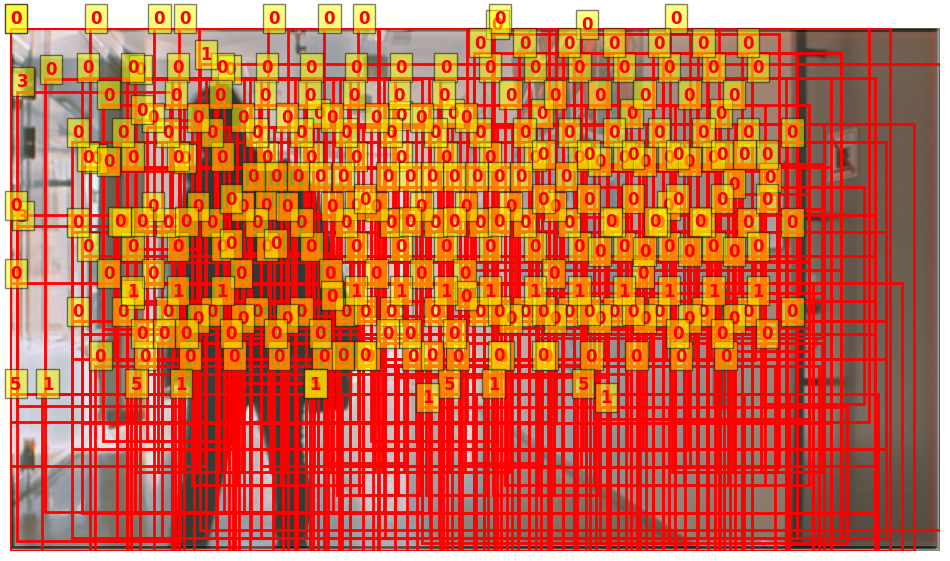

In [19]:
load_path = "drive/MyDrive/Generated Images/gen.png"
load_img = cv2.imread(load_path)
load_img = cv2.cvtColor(load_img, cv2.COLOR_BGR2RGB)

# Create a figure and an axes
fig, ax = plt.subplots(1, figsize=(12, 8))

# Display the image
ax.imshow(load_img)

# Add bounding boxes
# for (x_min, y_min, x_max, y_max) in bbox_arr:
for i, label in enumerate(labels_arr):
    # Create a Rectangle patch
    # if label != 0 and scores_arr[i]>0.08:
    # if label != 0:
    # print(label)
    x_min, y_min, x_max, y_max = bbox_arr[i]
    rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x_min, y_min - 10, label, color='red', fontsize=12, weight='bold', bbox=dict(facecolor='yellow', alpha=0.5))

# Remove axes and show the plot
ax.set_axis_off()
# plt.show()
annot_path = "drive/MyDrive/Generated Images/annot.png"
plt.savefig(annot_path, dpi=300, bbox_inches='tight', pad_inches=0.1)

In [17]:
annot_path = "drive/MyDrive/Generated Images/annot.png"
plt.savefig(annot_path, dpi=300, bbox_inches='tight', pad_inches=0.1)

<Figure size 640x480 with 0 Axes>